# Behavior Analysis: Duration Per Behavior Bout

Press SHIFT + ENTER to run code

### USER INPUT!

In [1]:
## Define project
project_name = 'project_acc_MiniscopeCap'

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['Combined']
selected_conditions = ['A_baseline','B_exp_cap','C_baseline_morphine','D_exp_morphine-cap']


### Main Code: Create Bar Graph of Duration Per Behavior Bout

/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/s

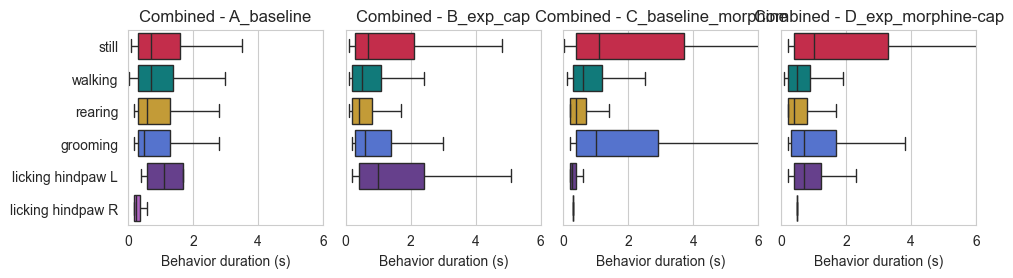

In [3]:
###### RUN DEPENDENCIES ######
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *
import matplotlib
import warnings
import seaborn as sns

###### Load Behaviors ######
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Define the directory path
directory_path = f"../processed_dataset/{project_name}/figures/behavior_instance-durations"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def get_duration_bouts(predict, behavior_classes, framerate=60):
    behav_durations = []
    bout_start_idx = np.where(np.diff(np.hstack([-1, predict])) != 0)[0]
    bout_durations = np.hstack([np.diff(bout_start_idx), len(predict) - np.max(bout_start_idx)])
    bout_start_label = predict[bout_start_idx]
    for b, behavior_name in enumerate(behavior_classes):
        idx_b = np.where(bout_start_label == int(b))[0]
        if len(idx_b) > 0:
            behav_durations.append(bout_durations[idx_b]/framerate)
        else:
            a = np.empty((1,))
            a[:] = np.nan
            behav_durations.append(a)
    return behav_durations

rows = len(selected_groups)
cols = len(selected_conditions)

# Adjust the figure size as needed
fig, ax = plt.subplots(rows, cols, figsize=(10, 11), sharex=False, sharey=True)

# Flatten ax if either rows or cols is 1
if rows == 1 or cols == 1:
    ax = np.atleast_1d(ax).flatten()

for row in range(rows):
    if row > 4:
        cols = 1
        if cols > 1:
            fig.delaxes(ax[row * cols + 1])
            fig.delaxes(ax[row * cols + 2])
    else:
        cols = len(selected_conditions)
        
    for col in range(cols):
        
        selected_group = selected_groups[row]
        selected_condition = selected_conditions[col]
        
        durations_ = []
        for f in range(len(behaviors[selected_group][selected_condition])):
            durations_.append(get_duration_bouts(behaviors[selected_group][selected_condition][f'file{f}'], behavior_names))
        durations_dict = {'behavior': np.hstack([np.hstack([np.repeat(behavior_names[i],
                                                           len(durations_[f][i])) 
                                                 for i in range(len(durations_[f]))]) for f in range(len(durations_))]),
                          'duration': np.hstack([np.hstack(durations_[f]) for f in range(len(durations_))]),
                          }
        durations_df = pd.DataFrame(durations_dict)
        durations_df.to_csv(f"../processed_dataset/{project_name}/figures/behavior_instance-durations/behavior_durations_{selected_group}_{selected_condition}.csv")

        # Plot using the correct ax indexing
        ax_index = row * cols + col
        sns.boxplot(data=durations_df, x='duration', y='behavior', hue='behavior', 
                    orient='h', width=0.8,
                    palette=behavior_colors, showfliers=False, ax=ax[ax_index])
        ax[ax_index].set_ylabel('')
        ax[ax_index].set_xlabel('')
        
        if col == 1 or col == 2:
            if row == rows-1:
                ax[ax_index].set_xlabel('Behavior duration (s)')
        
                
        if row == rows-1:
            ax[ax_index].set_xlabel('Behavior duration (s)')
        ax[ax_index].set_title(f'{selected_group} - {selected_condition}')
        
        ax[ax_index].set_aspect('equal', adjustable='box')
        
        ax[ax_index].set_xlim(0, 6)
        
        legend = ax[ax_index].get_legend()
        if legend is not None:
            legend.remove()
            
fig.savefig(f"../processed_dataset/{project_name}/figures/behavior_instance-durations/behavior_durations_{project_name}.svg", 
            dpi=600, bbox_inches='tight')
        
plt.tight_layout()
plt.show()

# ANALYSIS COMPLETE!